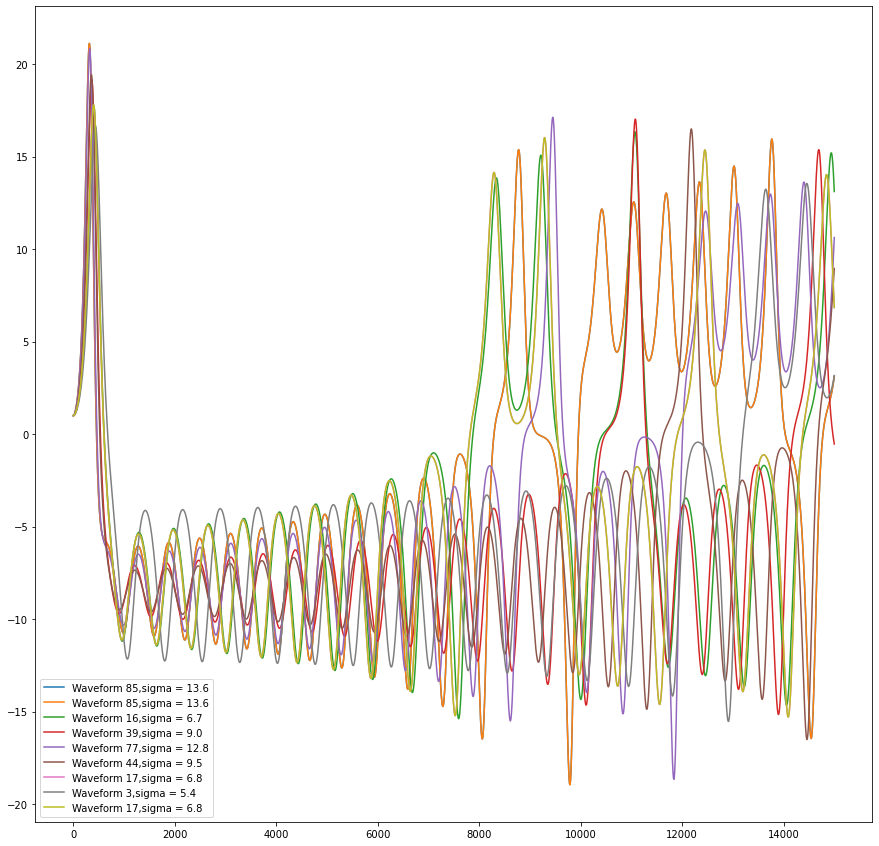

In [79]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import csv
import os
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001

plt.figure(figsize = [15, 15])
cols, rows = 3,3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(targets_t), size = (1,)).item()
    waveform = MegaVector[:,sample_idx]
    line = plt.plot(waveform, label=f"Waveform {str(sample_idx)},sigma = {targets[sample_idx].item()}")
plt.legend()
plt.show()


In [ ]:
class MyDataset(Dataset):
    def __init__(self, MegaVector_file, targets_file, transform = None, target_transform = None):
        self.MegaVector = pd.read_csv(MegaVector_file).to_numpy()
        self.targets = pd.read_csv(targets_file).to_numpy()
        self.MegaVector_t = torch.from_numpy(MegaVector.astype(np.float32)).to(device)
        self.targets_t = torch.from_numpy(targets.astype(np.float32)).to(device)


    def __len__(self):
        return len(self.targets_t)

    def __getitem__(self, idx):
        return self.MegaVector_t[:,idx],self.targets_t[idx]

    def signal_length(self,idx):
        return len(self.MegaVector_t[:,idx])

train_data = MyDataset("signals.csv", "targets.csv")
n_features = train_data.signal_length(10)
print(n_features)

In [92]:
print(train_data[20])

(tensor([ 1.0000,  1.0002,  1.0005,  ..., -0.9175, -0.8706, -0.8241],
       device='cuda:0'), tensor([7.1000], device='cuda:0'))


In [ ]:
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 4)
print(next(iter(train_dataloader)))

In [ ]:
class ParametersPredictor(nn.Module):
    def __init__(self, batch_size, n_input_features):
        super(ParametersPredictor, self).__init__()
        self.linear = nn.Linear(batch_size * n_input_features, 1000)
        self.linear2 = nn.Linear(1000, 1000)
        self.relu1 = nn.ReLU()
        self.linear3 = nn.Linear(1000, 1000)
        self.relu2 = nn.ReLU()
        self.linear4 = nn.Linear(1000, 10000)
        self.relu3 = nn.ReLU()
        self.linear5 = nn.Linear(10000, 1)


    def forward(self, x):
        out = self.linear(x)
        out = self.linear2(out)
        out = self.relu1(out)
        out = self.linear3(out)
        out = self.relu2(out)
        out = self.linear4(out)
        out = self.relu3(out)
        out = self.linear5(out)
        return out

In [95]:
NeuralNetwork = ParametersPredictor(n_input_features = n_features, batch_size = batch_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr=learning_rate)
total_loss = 0
EPOCHS = 100
for epoch in range(EPOCHS):
    for i,data in train_dataloader:
        predicted_y = NeuralNetwork(data[0])
        loss = criterion(data[1], predicted_y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # updates
        optimizer.step()
        total_loss += loss/batch_size

        # zero gradients
    print(f"Epoch: {epoch}. Loss: {total_loss:.8f}")
    total_loss = 0

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 239984x1000)